# Melanoma Detection using Convolutional Neural Networks

#### **Problem Statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing necessary libraries


In [93]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [2]:
## using the data by mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training images count: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Testing images count:", image_count_test)

Training images count:  2239
Testing images count: 118


- Out of the 2357 images, 2239 are used for training and 118 is used for testing.
- The images belong to 9 different classes.

## Loading the dataset


In [5]:
# defining parameters for images
num_classes = 9
batch_size = 32
img_height = 180
img_width = 180

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Using 80% of the images for training, and 20% for validation.

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualizing sample images from all the 9 classes

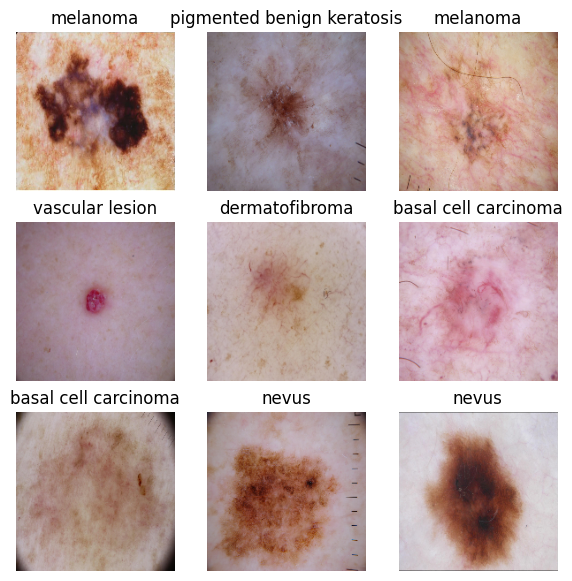

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

for imgs, labels in train_ds.take(1):
  for idx in range(9):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(imgs[idx].numpy().astype("uint64"))
    plt.title(class_names[labels[idx]])
    plt.axis("off")

In [10]:
for images, labels in train_ds:
  print(images.shape)
  print(labels.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

In [12]:
# Defining the model
model = Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [13]:
# compiling the model with an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
14/14 [==============================] - 46s 458ms/step - loss: 2.3043 - accuracy: 0.2953 - val_loss: 2.1417 - val_accuracy: 0.2148
Epoch 2/20
14/14 [==============================] - 0s 32ms/step - loss: 1.5707 - accuracy: 0.4430 - val_loss: 2.1318 - val_accuracy: 0.1924
Epoch 3/20
14/14 [==============================] - 0s 26ms/step - loss: 1.1157 - accuracy: 0.6286 - val_loss: 2.0572 - val_accuracy: 0.2371
Epoch 4/20
14/14 [==============================] - 0s 26ms/step - loss: 0.7813 - accuracy: 0.7450 - val_loss: 2.0264 - val_accuracy: 0.3221
Epoch 5/20
14/14 [==============================] - 0s 26ms/step - loss: 0.5313 - accuracy: 0.8389 - val_loss: 2.0427 - val_accuracy: 0.3669
Epoch 6/20
14/14 [==============================] - 0s 25ms/step - loss: 0.4247 - accuracy: 0.8501 - val_loss: 2.1178 - val_accuracy: 0.1812
Epoch 7/20
14/14 [==============================] - 0s 25ms/step - loss: 0.3842 - accuracy: 0.8770 - val_loss: 1.9463 - val_accuracy: 0.2931
Epoch 8/20


### Visualizing training results

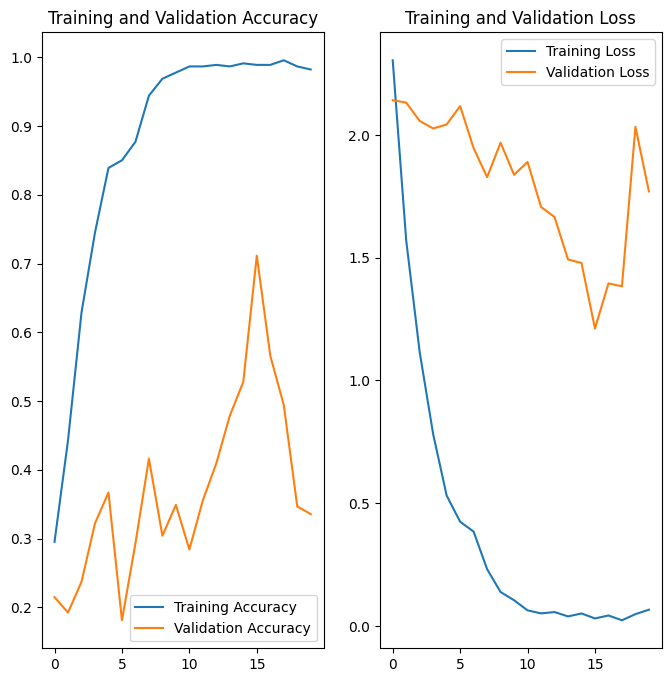

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- There is significant overfitting in the model. Though the training accuracy reached 98%, the validation accuracy is very low indicating that there is overfitting.

- Using data augmentation techniques along with dropouts will help in reducing the overfitting.

In [36]:
# data augmentation for the training set
data_augmentation_layers = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation((-0.3, 0.3))
])

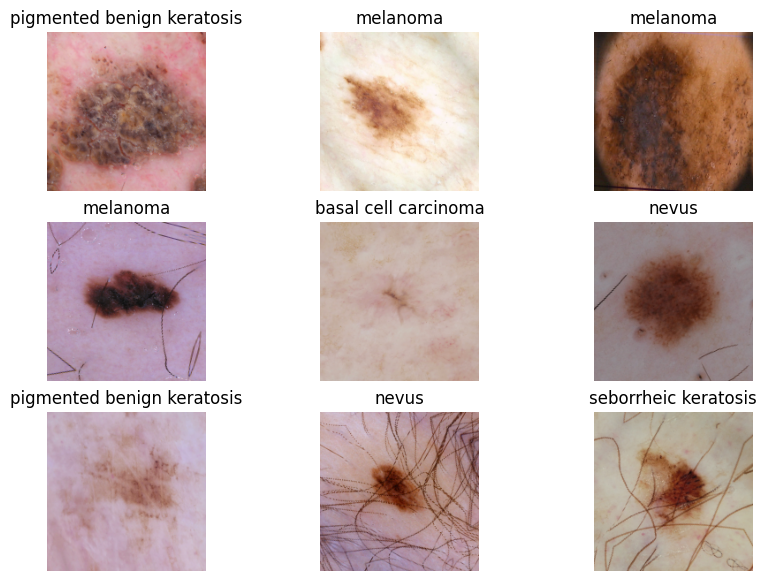

In [37]:
# visualizing how the augmentation strategy works for one instance of training image.
for img, labels in train_ds.take(1):
  plt.figure(figsize=(10, 7))
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(data_augmentation_layers(img)[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create a new model with data augmentation and dropouts


In [89]:
# Defining the a new model with dropouts
# Reducing model complexity by reducing the layers
model_1 = Sequential([
    data_augmentation_layers,
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [90]:
# compiling the model with an appropirate optimiser and loss function
model_1.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [91]:
history = model_1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
14/14 [==============================] - 3s 99ms/step - loss: 15.3684 - accuracy: 0.1723 - val_loss: 2.2048 - val_accuracy: 0.2013
Epoch 2/20
14/14 [==============================] - 1s 84ms/step - loss: 2.0192 - accuracy: 0.2595 - val_loss: 1.9267 - val_accuracy: 0.2438
Epoch 3/20
14/14 [==============================] - 1s 84ms/step - loss: 1.8450 - accuracy: 0.3691 - val_loss: 1.6653 - val_accuracy: 0.3982
Epoch 4/20
14/14 [==============================] - 1s 84ms/step - loss: 1.7319 - accuracy: 0.4228 - val_loss: 1.6061 - val_accuracy: 0.4049
Epoch 5/20
14/14 [==============================] - 1s 86ms/step - loss: 1.5751 - accuracy: 0.4072 - val_loss: 1.6593 - val_accuracy: 0.3803
Epoch 6/20
14/14 [==============================] - 1s 89ms/step - loss: 1.5774 - accuracy: 0.4452 - val_loss: 1.5780 - val_accuracy: 0.4676
Epoch 7/20
14/14 [==============================] - 1s 90ms/step - loss: 1.6180 - accuracy: 0.4564 - val_loss: 1.9810 - val_accuracy: 0.3311
Epoch 8/20
1

### Visualizing the results

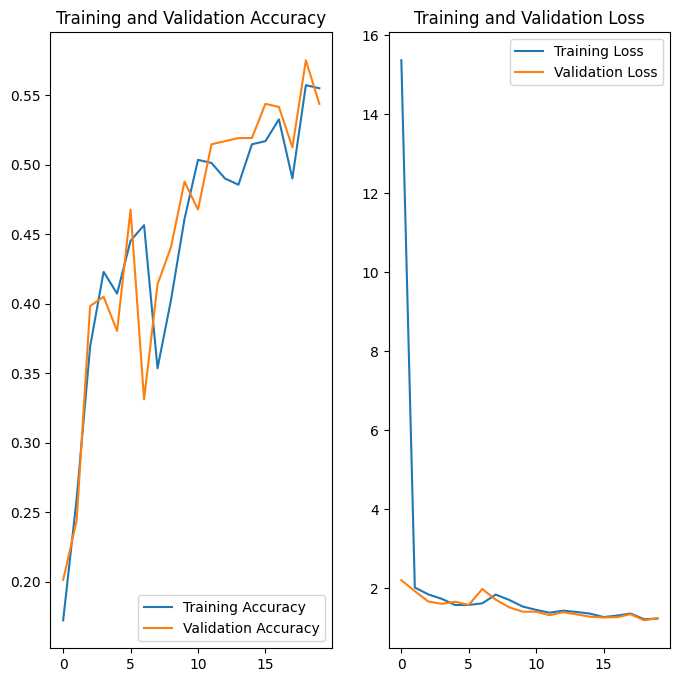

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Compared to the previous model, the overfitting has been almost removed. The training and validation accuracies are very close to each other.
- Due to the regularization techniques, the model's accuracy is lesser than the previous model but training it for few more epochs will make the model perform better than the previous one.

### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 2500x1000 with 0 Axes>

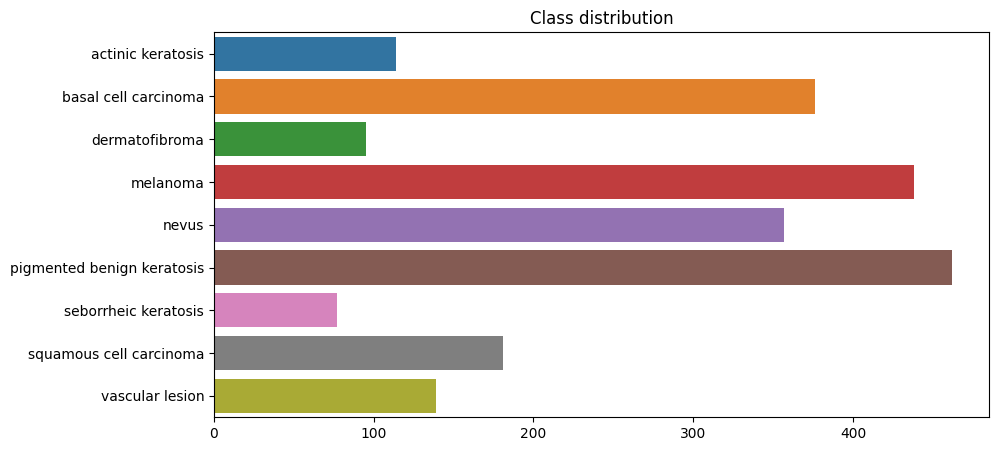

In [102]:
class_counts=[]
for c in class_names:
    class_counts.append(len(list(data_dir_train.glob(f'{c}/*.jpg'))))
plt.figure(figsize=(25,10))

plt.figure(figsize=(10, 5))
sns.barplot(y=class_names, x=class_counts)
plt.title("Class distribution")
plt.show()

#### Findings:
#### Which class has the least number of samples?
#### Ans: Seborrheic Keratosis
#### Which classes dominate the data in terms proportionate number of samples?
#### Ans: Pigmented benign keratosis


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [103]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [105]:
path_to_training_dataset = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F43D0A79270>: 100%|██████████| 500/500 [00:23<00:00, 21.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F446C467880>: 100%|██████████| 500/500 [00:21<00:00, 23.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F43D1690280>: 100%|██████████| 500/500 [00:21<00:00, 22.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7F446C4661A0>: 100%|██████████| 500/500 [01:52<00:00,  4.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F43D0E83A00>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F43D17DFBE0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F43D0CD5360>: 100%|██████████| 500/500 [00:48<00:00, 10.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F451368BC70>: 100%|██████████| 500/500 [00:22<00:00, 22.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F446D281B10>: 100%|██████████| 500/500 [00:21<00:00, 23.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [106]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Now we have 4500 images in the training set.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [114]:
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [115]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [116]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [118]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [119]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating a new model

In [124]:
model_2 = Sequential([
    data_augmentation_layers,
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [125]:
model_2.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [126]:
epochs = 50
history = model_2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
169/169 [==============================] - 38s 201ms/step - loss: 2.3839 - accuracy: 0.3034 - val_loss: 1.5978 - val_accuracy: 0.3853
Epoch 2/50
169/169 [==============================] - 39s 227ms/step - loss: 1.5585 - accuracy: 0.3991 - val_loss: 1.4924 - val_accuracy: 0.4172
Epoch 3/50
169/169 [==============================] - 35s 200ms/step - loss: 1.5031 - accuracy: 0.4149 - val_loss: 1.4407 - val_accuracy: 0.4514
Epoch 4/50
169/169 [==============================] - 36s 203ms/step - loss: 1.4883 - accuracy: 0.4279 - val_loss: 1.5336 - val_accuracy: 0.3935
Epoch 5/50
169/169 [==============================] - 35s 201ms/step - loss: 1.4467 - accuracy: 0.4407 - val_loss: 1.4776 - val_accuracy: 0.4410
Epoch 6/50
169/169 [==============================] - 39s 226ms/step - loss: 1.4119 - accuracy: 0.4577 - val_loss: 1.4365 - val_accuracy: 0.4529
Epoch 7/50
169/169 [==============================] - 41s 234ms/step - loss: 1.3701 - accuracy: 0.4716 - val_loss: 1.5616 - val_ac

#### Visualize the model results

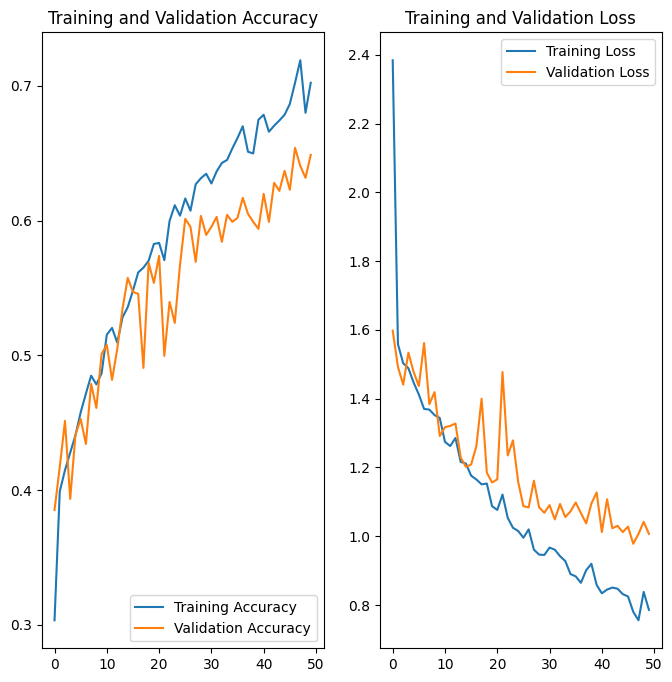

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Evaluating the final model on validation set



In [132]:
data_dir_test="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [137]:
model_2.evaluate(val_ds)

43/43 [==============================] - 9s 158ms/step - loss: 1.0068 - accuracy: 0.6488


[1.0068432092666626, 0.6488493084907532]

After balancing the classes, we have a 64% accurate model.